In [106]:
import glob
import json
import warnings

import pandas as pd
import plotly.express as px
import torch
from datasets import load_dataset
from evaluate.visualization import radar_plot
from tqdm.autonotebook import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer

from mva_snlp_canine.nli.tokenize_dataset import tokenize_example
from mva_snlp_canine.nli.train_models import compute_metrics

In [4]:
language = "ar"

In [7]:
dataset = load_dataset("xnli", language, split="test")
print(f"--- Language {language}: {len(dataset)}")

dataset = dataset.rename_columns(
    {
        "premise": "choosen_premise",
        "hypothesis": "choosen_hypothesis",
        "label": "label",
    }
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Dataset xnli downloaded and prepared to /home/gwatk/.cache/huggingface/datasets/xnli/ar/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd. Subsequent calls will reuse this data.
--- Language ar: 5010


In [8]:
dataset[0:3]

{'choosen_premise': ['حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطاً تماما ،وأنهيت الحديث معه مرة ثانية .',
  'حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطاً تماما ،وأنهيت الحديث معه مرة ثانية .',
  'حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطاً تماما ،وأنهيت الحديث معه مرة ثانية .'],
 'choosen_hypothesis': ['لم أتحدث معه مرة أخرى.',
  'كنت مستاء جدا لدرجة أنني بدأت بالحديث معه مرة أخرى.',
  'دار بيننا حديث رائع.'],
 'label': [2, 0, 1]}

In [9]:
exp_dir = "nli_results/200k_ar_tr"

In [12]:
trainer_states = glob.glob(f"{exp_dir}/models/**/trainer_state.json")

In [16]:
for file in trainer_states:
    with open(file) as f:
        trainer_state = json.load(f)

In [55]:
trainer_state["best_model_checkpoint"]

'nli_results/200k_ar_tr/models/_canine_c/checkpoint-18750'

In [104]:
model_path = trainer_state["best_model_checkpoint"]
print(f"Best model checkpoint: {trainer_state['best_model_checkpoint']}")

tokenizer = AutoTokenizer.from_pretrained(trainer_state["best_model_checkpoint"])
model = AutoModelForSequenceClassification.from_pretrained(
    trainer_state["best_model_checkpoint"]
)
model.eval();

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


Best model checkpoint: nli_results/200k_ar_tr/models/_canine_c/checkpoint-18750


In [96]:
examples = tokenizer(
    dataset[0:8]["choosen_premise"],
    dataset[0:8]["choosen_hypothesis"],
    return_tensors="pt",
    padding=True,
    truncation=True,
)

In [107]:
print("--- Tokenizing the dataset...")
tdataset = dataset.map(
    tokenize_example,
    num_proc=12,
    fn_kwargs={"tokenizer": tokenizer, "max_length": None},
)

tdataset = tdataset.select_columns(
    ["input_ids", "attention_mask", "token_type_ids", "label"]
)

--- Tokenizing the dataset...


Map (num_proc=12):   0%|          | 0/5010 [00:00<?, ? examples/s]

In [157]:
def evaluate_model_on_language(model_path: str, language: str):
    """Evaluate the model on the test dataset of the given language."""
    model_name = model_path.split("/")[-2].strip("_")
    print(f"=== Language : {language} | Model : {model_name}")
    dataset = load_dataset("xnli", language, split="test")

    dataset = dataset.rename_columns(
        {
            "premise": "choosen_premise",
            "hypothesis": "choosen_hypothesis",
            "label": "label",
        }
    )

    print(f"--- Loading the model and tokenizer from {model_path}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    print("--- Tokenizing the dataset...")
    dataset = dataset.map(
        tokenize_example,
        num_proc=12,
        fn_kwargs={"tokenizer": tokenizer, "max_length": None},
    )

    dataset = dataset.select_columns(
        ["input_ids", "attention_mask", "token_type_ids", "label"]
    )

    print(f"--- Cuda is available: {torch.cuda.is_available()}")

    trainer = Trainer(
        model=model,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    print("--- Evaluating the model...")
    predictions, label_ids, metrics = trainer.predict(dataset)
    metrics["language"] = language
    metrics["model_path"] = model_path
    metrics["model"] = model_name

    return predictions, label_ids, metrics

In [127]:
exp_dir = "nli_results/200k_ar_tr"

language_subset = [
    "en",
    "ar",
    "fr",
    "es",
    "de",
    "el",
    "bg",
    "ru",
    "tr",
    "zh",
    "th",
    "vi",
    "hi",
    "ur",
    "sw",
]

trainer_states = glob.glob(f"{exp_dir}/models/**/trainer_state.json")

In [155]:
warnings.filterwarnings("ignore")

In [156]:
language_metrics = []
language_predictions = {}
language_label_ids = {}
for language in tqdm(language_subset):
    for file in trainer_states:
        with open(file) as f:
            trainer_state = json.load(f)
        predictions, label_ids, metrics = evaluate_model_on_language(
            trainer_state["best_model_checkpoint"], language
        )
        language_metrics.append(metrics)
        language_predictions[language] = predictions
        language_label_ids[language] = label_ids

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_toke

In [161]:
metrics_df = pd.DataFrame(language_metrics)

In [162]:
metrics_df

,test_loss,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_runtime,test_samples_per_second,test_steps_per_second,language,model_path,model
0,1.060375,0.472455,0.469053,0.469293,0.472455,18.1147,276.571,34.613,en,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s
1,1.000458,0.587425,0.571682,0.642902,0.587425,10.2490,488.829,61.177,en,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert
2,1.085168,0.492615,0.485814,0.493514,0.492615,18.8172,266.246,33.321,en,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c
3,0.908508,0.594611,0.592519,0.613616,0.594611,16.3440,306.535,38.363,ar,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s
4,0.848376,0.618762,0.617911,0.636501,0.618762,12.7894,391.730,49.025,ar,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert
5,0.887389,0.602994,0.602307,0.621194,0.602994,16.1868,309.511,38.735,ar,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c
6,1.057603,0.488623,0.480769,0.484602,0.488623,20.8189,240.647,30.117,fr,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s
7,0.890555,0.612575,0.609294,0.621283,0.612575,11.9029,420.907,52.676,fr,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert
8,1.074592,0.491417,0.486094,0.489999,0.491417,20.4022,245.562,30.732,fr,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c
9,1.072156,0.483034,0.473682,0.479794,0.483034,19.4626,257.416,32.216,es,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s


In [192]:
metrics_df = pd.DataFrame(language_metrics)
sub_df = metrics_df[metrics_df["language"].isin(["ar", "tr", "ur"])]
sub_df.rename(
    columns={
        "test_loss": "loss",
        "test_accuracy": "accuracy",
        "test_f1_weighted": "f1",
        "test_precision_weighted": "precision",
        "test_recall_weighted": "recall",
        "test_runtime": "runtime",
        "test_samples_per_second": "samples_per_second",
    },
    inplace=True,
)
data = sub_df[
    ["loss", "accuracy", "f1", "precision", "recall", "runtime", "samples_per_second"]
]
model_names = list(sub_df["model"] + " (" + sub_df["language"] + ")")
sub_df["model_name"] = model_names

In [182]:
data

,loss,accuracy,f1,precision,recall,runtime,samples_per_second
3,0.908508,0.594611,0.592519,0.613616,0.594611,16.3440,306.535
4,0.848376,0.618762,0.617911,0.636501,0.618762,12.7894,391.730
5,0.887389,0.602994,0.602307,0.621194,0.602994,16.1868,309.511
24,0.874684,0.608982,0.607020,0.627329,0.608982,18.8656,265.562
25,0.833474,0.632136,0.630637,0.646314,0.632136,12.4939,400.996
26,0.881846,0.614770,0.612890,0.632502,0.614770,18.4240,271.928
39,1.176206,0.428942,0.405444,0.421876,0.428942,17.8171,281.190
40,1.005085,0.546906,0.547035,0.550100,0.546906,14.1929,352.993
41,1.147777,0.431138,0.424150,0.432970,0.431138,18.0731,277.208


In [201]:
theta = ["loss", "accuracy", "f1", "precision", "recall"]
sub_df[theta]
sub_df[theta].values[0]
sub_df

,loss,accuracy,f1,precision,recall,runtime,samples_per_second,test_steps_per_second,language,model_path,model,model_name
3,0.908508,0.594611,0.592519,0.613616,0.594611,16.3440,306.535,38.363,ar,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s,canine_s (ar)
4,0.848376,0.618762,0.617911,0.636501,0.618762,12.7894,391.730,49.025,ar,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert,bert (ar)
5,0.887389,0.602994,0.602307,0.621194,0.602994,16.1868,309.511,38.735,ar,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c,canine_c (ar)
24,0.874684,0.608982,0.607020,0.627329,0.608982,18.8656,265.562,33.235,tr,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s,canine_s (tr)
25,0.833474,0.632136,0.630637,0.646314,0.632136,12.4939,400.996,50.184,tr,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert,bert (tr)
26,0.881846,0.614770,0.612890,0.632502,0.614770,18.4240,271.928,34.032,tr,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c,canine_c (tr)
39,1.176206,0.428942,0.405444,0.421876,0.428942,17.8171,281.190,35.191,ur,nli_results/200k_ar_tr/models/_canine_s/checkp...,canine_s,canine_s (ur)
40,1.005085,0.546906,0.547035,0.550100,0.546906,14.1929,352.993,44.177,ur,nli_results/200k_ar_tr/models/_bert/checkpoint...,bert,bert (ur)
41,1.147777,0.431138,0.424150,0.432970,0.431138,18.0731,277.208,34.693,ur,nli_results/200k_ar_tr/models/_canine_c/checkp...,canine_c,canine_c (ur)


In [202]:
theta = ["loss", "accuracy", "f1", "precision", "recall"]
fig = px.line_polar(sub_df, r=sub_df[theta].values[0], theta=theta, line_close=True)

In [ ]:
fig.show()

In [ ]:
fig = px.line_polar(sub_df, r="r", theta="theta", line_close=True)
fig.show()

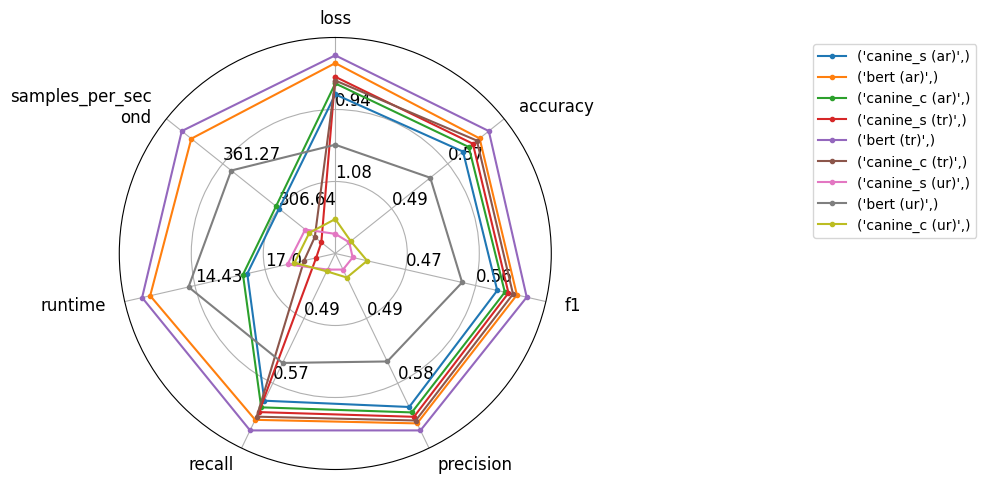

In [177]:
plot = radar_plot(data=data, model_names=model_names, invert_range=["loss", "runtime"])
plot.show()

In [ ]:
# data = [
#     {"accuracy": 0.99, "precision": 0.8, "f1": 0.95, "latency_in_seconds": 33.6},
#     {"accuracy": 0.98, "precision": 0.87, "f1": 0.91, "latency_in_seconds": 11.2},
#     {"accuracy": 0.98, "precision": 0.78, "f1": 0.88, "latency_in_seconds": 87.6},
#     {"accuracy": 0.88, "precision": 0.78, "f1": 0.81, "latency_in_seconds": 101.6},
# ]
# model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]

In [112]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
predictions, label_ids, metrics = trainer.predict(tdataset)

In [122]:
metrics["language"] = language
metrics["model_path"] = model_path
metrics["model"] = model_path.split("/")[-2].strip("_")

In [125]:
pd.DataFrame([metrics] * 2)

,test_loss,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_runtime,test_samples_per_second,test_steps_per_second,language,model,model_path
0,0.887389,0.602994,0.602307,0.621194,0.602994,18.5304,270.367,33.836,ar,canine_c,nli_results/200k_ar_tr/models/_canine_c/checkp...
1,0.887389,0.602994,0.602307,0.621194,0.602994,18.5304,270.367,33.836,ar,canine_c,nli_results/200k_ar_tr/models/_canine_c/checkp...


In [99]:
model(**examples).logits.argmax(dim=1)

tensor([0, 1, 2, 1, 0, 1, 2, 0])

In [32]:
def trainer_state_to_df(trainer_state):
    df = pd.DataFrame(trainer_state["log_history"])
    # create a column that states if it is a training or an evaluation or a test run, using the fact that loss is NaN for evaluation and test, eval_loss is NaN for training and test, and eval_accuracy is NaN for training and test, an that train_runtime is not nan for test
    df["run_type"] = "train"
    df.loc[df["eval_loss"].notna(), "run_type"] = "eval"
    df.loc[df["train_runtime"].notna(), "run_type"] = "test"
    return df

In [33]:
df = trainer_state_to_df(trainer_state)